Reinforcement Learning Strategy Selector for DOGEUSDT Futures

In [ ]:
!pip install numpy pandas ta scikit-learn gymnasium stable-baselines3 ccxt torch matplotlib


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import ta
import gymnasium as gym

from sklearn.preprocessing import StandardScaler
from stable_baselines3 import DQN

import ccxt


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=

In [14]:
exchange = ccxt.coinbase({
    'options': {'defaultType': 'future'}
})

symbol = "DOGE/USDT"
timeframe = "15m"
limit = 1500

def fetch_ohlcv(symbol, timeframe, limit):
    data = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)
    df = pd.DataFrame(
        data,
        columns=["timestamp", "open", "high", "low", "close", "volume"]
    )
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
    return df

df = fetch_ohlcv(symbol, timeframe, limit)
df.head()


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,timestamp,open,high,low,close,volume
0,2026-01-09 15:30:00,0.1427,0.1446,0.1422,0.1425,502675.2
1,2026-01-09 15:45:00,0.1429,0.1433,0.1410,0.1424,338691.8
2,2026-01-09 16:00:00,0.1423,0.1440,0.1421,0.1439,63480.3
3,2026-01-09 16:15:00,0.1440,0.1442,0.1431,0.1433,112648.5
4,2026-01-09 16:30:00,0.1431,0.1433,0.1429,0.1433,42186.9


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [15]:
df.tail()

,timestamp,open,high,low,close,volume
220,2026-01-12 17:15:00,0.1389,0.1391,0.1380,0.1380,11486.9
221,2026-01-12 17:30:00,0.1380,0.1380,0.1368,0.1379,56990.8
222,2026-01-12 17:45:00,0.1379,0.1380,0.1378,0.1380,15526.0
223,2026-01-12 18:00:00,0.1388,0.1390,0.1386,0.1388,19806.0
224,2026-01-12 18:15:00,0.1388,0.1389,0.1387,0.1387,58563.5


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [16]:
def compute_indicators(df):
    df = df.copy()

    df["rsi"] = ta.momentum.RSIIndicator(df["close"], 14).rsi()
    df["sma_fast"] = df["close"].rolling(5).mean()
    df["sma_slow"] = df["close"].rolling(10).mean()

    bb = ta.volatility.BollingerBands(df["close"], 20)
    df["bb_high"] = bb.bollinger_hband()
    df["bb_low"] = bb.bollinger_lband()

    df["momentum"] = df["close"] - df["close"].shift(20)

    df["vwap"] = ta.volume.VolumeWeightedAveragePrice(
        df["high"], df["low"], df["close"], df["volume"], 20
    ).volume_weighted_average_price()

    df.dropna(inplace=True)
    return df

df = compute_indicators(df)
df.tail()


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,timestamp,open,high,low,close,volume,rsi,sma_fast,sma_slow,bb_high,bb_low,momentum,vwap
220,2026-01-12 17:15:00,0.1389,0.1391,0.1380,0.1380,11486.9,50.637078,0.13918,0.13861,0.140098,0.134862,0.0013,0.137061
221,2026-01-12 17:30:00,0.1380,0.1380,0.1368,0.1379,56990.8,49.809950,0.13876,0.13871,0.140140,0.134930,0.0011,0.137124
222,2026-01-12 17:45:00,0.1379,0.1380,0.1378,0.1380,15526.0,50.677578,0.13844,0.13872,0.140183,0.135017,0.0013,0.137159
223,2026-01-12 18:00:00,0.1388,0.1390,0.1386,0.1388,19806.0,57.071101,0.13832,0.13877,0.140292,0.135148,0.0024,0.137234
224,2026-01-12 18:15:00,0.1388,0.1389,0.1387,0.1387,58563.5,56.092301,0.13828,0.13879,0.140333,0.135377,0.0027,0.137607


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [17]:
def rsi_strategy(row):
    if row["rsi"] < -1.0:
        return 1
    elif row["rsi"] > 1.0:
        return -1
    return 0

def sma_strategy(row):
    return 1 if row["sma_fast"] > row["sma_slow"] else -1

def bb_strategy(row):
    if row["close"] < row["bb_low"]:
        return 1
    elif row["close"] > row["bb_high"]:
        return -1
    return 0

def momentum_strategy(row):
    return 1 if row["momentum"] > 0 else -1

def vwap_strategy(row):
    return 1 if row["close"] > row["vwap"] else -1

STRATEGIES = [
    rsi_strategy,
    sma_strategy,
    bb_strategy,
    momentum_strategy,
    vwap_strategy
]


In [18]:
class StrategyTradingEnv(gym.Env):
    def __init__(self, df, strategies, leverage=3):
        self.df = df.reset_index(drop=True)
        self.strategies = strategies
        self.leverage = leverage

        self.action_space = gym.spaces.Discrete(len(strategies))
        self.observation_space = gym.spaces.Box(
            low=-np.inf, high=np.inf, shape=(6,), dtype=np.float32
        )

        self.reset()

    def reset(self, seed=None):
        self.idx = 1
        self.nav = 1.0
        self.position = 0
        return self._get_obs(), {}

    def _get_obs(self):
        r = self.df.iloc[self.idx]
        return np.array([
            r["rsi"],
            r["sma_fast"] - r["sma_slow"],
            r["close"] - r["bb_low"],
            r["bb_high"] - r["close"],
            r["momentum"],
            r["close"] - r["vwap"]
        ], dtype=np.float32)

    def step(self, action):
        r = self.df.iloc[self.idx]
        prev = self.df.iloc[self.idx - 1]

        signal = self.strategies[action](r)

        if signal == 0:
            signal = self.position

        log_return = np.log(
            (r["close"] + 1e-8) / (prev["close"] + 1e-8)
        )

        reward = self.leverage * signal * log_return

        # churn penalty
        reward -= 0.0002 * abs(signal - self.position)

        self.position = signal
        self.nav *= np.exp(reward)

        self.idx += 1
        done = self.idx >= len(self.df) - 1

        return self._get_obs(), reward, done, False, {"nav": self.nav}


In [19]:
env = StrategyTradingEnv(df, STRATEGIES, leverage=3)

model = DQN(
    "MlpPolicy",
    env,
    learning_rate=3e-4,
    buffer_size=200_000,
    batch_size=128,
    gamma=0.99,
    exploration_fraction=0.3,
    policy_kwargs=dict(net_arch=[128, 128]),
    verbose=1
)

model.learn(total_timesteps=1_000_000)


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 203      |
|    ep_rew_mean      | 0.146    |
|    exploration_rate | 0.997    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1053     |
|    time_elapsed     | 0        |
|    total_timesteps  | 812      |
| train/              |          |
|    learning_rate    | 0.0003   |
|    loss             | 0.0319   |
|    n_updates        | 177      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 203      |
|    ep_rew_mean      | 0.0871   |
|    exploration_rate | 0.995    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1013     |
|    time_elapsed     | 1        |
|    total_timesteps  | 1624     |
| train/              |       

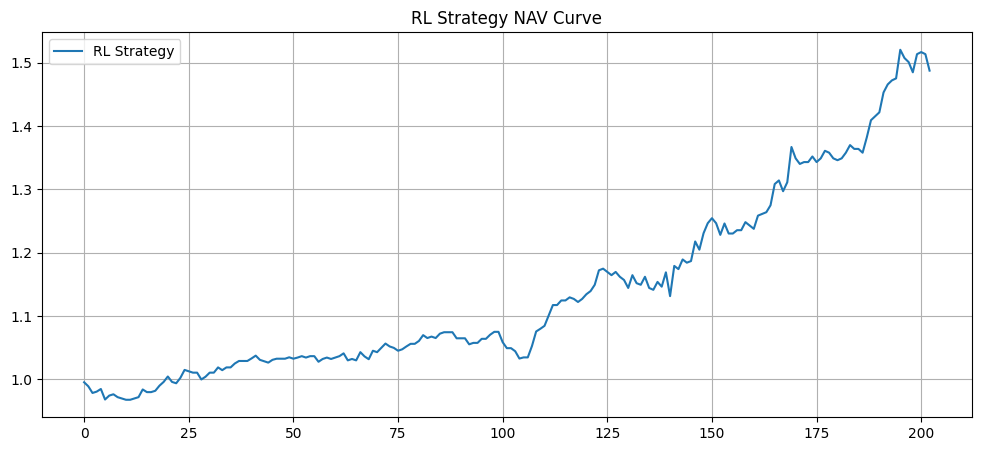

Final NAV: 1.487698045521947


In [20]:
obs, _ = env.reset()
done = False

nav_curve = []

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, info = env.step(action)
    nav_curve.append(info["nav"])

plt.figure(figsize=(12,5))
plt.plot(nav_curve, label="RL Strategy")
plt.title("RL Strategy NAV Curve")
plt.grid()
plt.legend()
plt.show()

print("Final NAV:", nav_curve[-1])


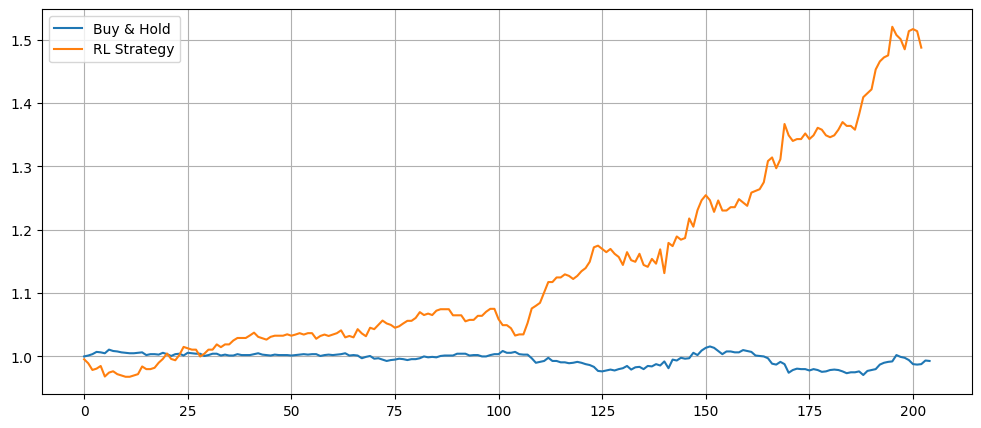

In [21]:
prices = df["close"].values
bh_nav = prices / prices[0]

plt.figure(figsize=(12,5))
plt.plot(bh_nav, label="Buy & Hold")
plt.plot(nav_curve, label="RL Strategy")
plt.legend()
plt.grid()
plt.show()


In [1]:
split = int(len(df) * 0.7)
train_df = df.iloc[:split]
test_df = df.iloc[split:]


NameError: name 'df' is not defined